# How cyclical is *One Hundred Years of Solitude*?

I play with the text using Scipy's signal processing library to gather some statistics. Detailed report coming soon.

In [316]:
from datascience import *
import gensim
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Clustering
from sklearn.metrics import pairwise
from sklearn.manifold import MDS

# Text Processing
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.corpus import words

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

# POS and NER Tagging
from nltk.tag.perceptron    import PerceptronTagger
from nltk.tag.brill         import BrillTagger
from nltk.tag.stanford      import StanfordTagger, StanfordPOSTagger, StanfordNERTagger
from nltk import pos_tag
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import ne_chunk

# Character trends
from scipy import signal, constants

# Saving computed objects to the file system
import pickle
import os

# Reading in One Hundred Years of Solitude

In [317]:
with open('hundred_years.txt', 'r') as h:
    hundred_years_text = h.read()

To make my analysis easier, I want to swap Aureliano Segundo with Jose Arcadio Segundo. Sufficient evidence in the books shows that Jose Arcadio Segundo has the traits of all the other Aureliano in the family and Aureliano Segundo has the traits of all the other Arcadios.

In [318]:
def hundred_years_processing(text):
    return text.replace('Aureliano Segundo', '<temp>')\
              .replace('José Arcadio Segundo', 'Aureliano Segundo')\
              .replace('<temp>', 'José Arcadio Segundo')\
              .replace('José Arcadio Buendía', '<headoffamily>')\
              .replace('Meme', 'Remedios')

# Utilities

In [319]:
def flatten(lst):
    return [item for sublist in lst for item in sublist]

## Text Processing Functions

In [320]:
def clean_text(text, language):
    stemmer = SnowballStemmer(language)

    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
        
    # Tokenize, remove stopwords and stem
    words = [stemmer.stem(token.lower()) for token in text.split() 
                     if token.lower() not in ENGLISH_STOP_WORDS]
    return words

def split_words(chapters, language):
    """
    >>> split_words(['happy birthday', 'to you special one'], 'english')
    [['happi', 'birthday'], ['special']]
    >>> split_words(['feliz cumpleaños', 'querido Diego'], 'spanish')
    [['feliz', 'cumpleañ'], ['quer', 'dieg']]
    """
    return [clean_text(chapter, language) for chapter in chapters]

# Character Appearances

## Plotting Character Keywords over Time

In [321]:
def periodicity(vector):
    """
    Return the periodicity of a vector.
    Note that a period of inf means aperiodic.
    
    Source: http://stackoverflow.com/questions/11205037/detect-period-of-unknown-source
    """
    # FFT converts appearance trend in time-domain to frequency domain
    # np.fft.fft has the values
    char_fft = np.fft.fft(vector)
    frequencies = np.fft.fftfreq(len(vector), 1)

    # Find the indices with the strongest values
    threshold = 10 **2
    candidates = np.where(abs(char_fft) > threshold)
    if len(candidates[0]) == 0:
        return np.inf
    index = candidates[0][-1]

    # period is 1 / frequency
    return (1 / abs(frequencies[index]))

class Text:
    """
    The text should already be cleaned and tokenized.
    
    words - the text as a list of words
    """
    def __init__(self, text, lang, text_fn):
        self.text = text
        self.lang = lang
        self.process_text(text_fn)
        
    def process_text(self, text_fn):
        self.text = text_fn(self.text)
        self.words = clean_text(self.text, self.lang)
        
    def appearances(self, char_name, bin_size, normalize=False):
        """
        An array of the counts of a particular word. Only one-word character names supported for now.
        """
        index_bin_start = 0
        values = []
        while index_bin_start < len(self.words):
            section_total = 0
            for index_in_bin in range(bin_size):
                if index_bin_start + index_in_bin >= len(self.words):
                    break
                if isinstance(char_name, list) and self.words[index_bin_start + index_in_bin] in char_name\
                    or self.words[index_bin_start + index_in_bin] == char_name:
                    section_total += 1
            index_bin_start += bin_size
            values.append(section_total)
        return np.array(values) / max(values) if normalize else np.array(values)

    def plot_char_appearances(self, names, normalize=True, bin_size=1000):
        """
        If the text contains "Chapter", gray lines representing where "Chapter" appears will be drawn in the plot.
        """
        appearances_tb = Table()
        for name in names:
            name_label = ', '.join(name) if isinstance(name, list) else name
            appearances_tb.append_column(name_label, self.appearances(name, bin_size, normalize))

        plt.figure(figsize=(10, 5))
        for i in range(len(names)):
            plt.plot(np.arange(len(appearances_tb.column(0))), appearances_tb.column(i), label=names[i])
        plt.legend()

        # Add chapter lines
        for index, elem in enumerate(self.words):
            if elem == 'chapter':
                plt.axvline(index // bin_size, color='lightgray')
                
    def gather_char_data(self, names):
        """
        There should be at least 10 time points for something meaningful, and at least 500 words per bin.
        This will have to be changed depending on the overall length of the text.
        """
        char_signals_tb = Table(['Name', 'Bin Size', 'Appearances', 'Periodicity', 'Peaks'])
        bin_size = 500
        text_len = len(self.words)
        num_bins = text_len // bin_size
        while num_bins > 10:
            for name in names:
                char_appearances = self.appearances(name, bin_size)
                char_period = periodicity(char_appearances) * bin_size
                
                # Widest peak will cover at most num_bins // 5 = 20% of the bins
                peaks = set(signal.find_peaks_cwt(char_appearances, np.arange(1, num_bins // 5)))
                
                # {0: char_appearances} is a hacky way to get around datascience bug
                name_label = ', '.join(name) if isinstance(name, list) else name
                char_signals_tb.append([name_label, bin_size, {0: char_appearances}, char_period, peaks])
            bin_size += 500
            num_bins = text_len // bin_size
            
        return char_signals_tb

In [322]:
# Create a text object
hundred_years = Text(hundred_years_text, 'english', hundred_years_processing)

In [323]:
# Example for finding peaks
aureliano_appearances = hundred_years.appearances('aureliano', 2000)
signal.find_peaks_cwt(aureliano_appearances, np.arange(1, 6))

[4, 11, 12, 17, 23, 27]

In [324]:
# Example for finding period
arcadio_appearances = hundred_years.appearances('arcadio', 2000)
periodicity(arcadio_appearances) * 2000

12400.0

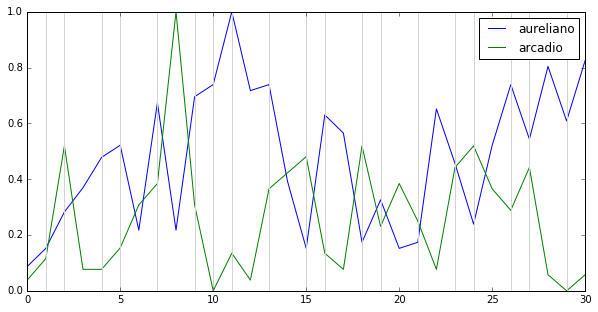

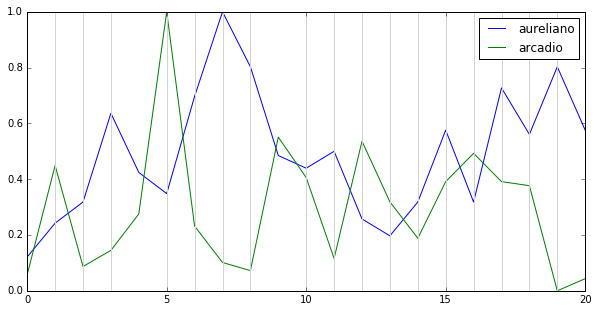

In [325]:
# Example of plotting character appearances
hundred_years.plot_char_appearances(['aureliano', 'arcadio'], normalize=True, bin_size=2000)
hundred_years.plot_char_appearances(['aureliano', 'arcadio'], normalize=True, bin_size=3000)

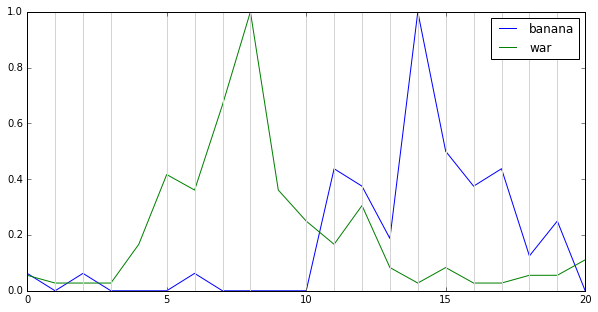

In [326]:
hundred_years.plot_char_appearances(['banana', 'war'], bin_size=3000)
# What a striking plot!

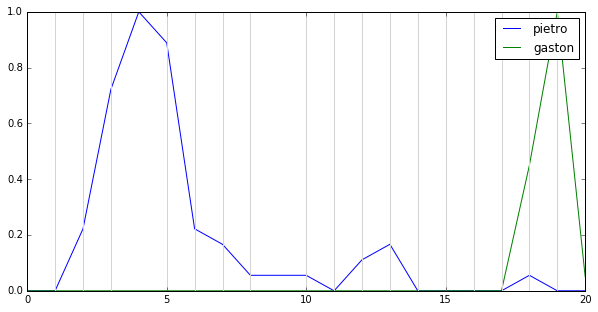

In [327]:
hundred_years.plot_char_appearances(['pietro', 'gaston'], bin_size=3000)
# There is some symmetry in this plot as well

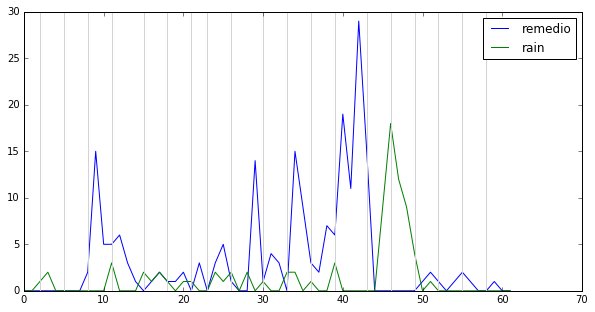

In [328]:
hundred_years.plot_char_appearances(['remedio', 'rain'], bin_size=1000, normalize=False)
# How significant is this plot?

# Computed Statistics

In [329]:
# Note that the words are stemmed
chars = [
        # Buendia family
        'aureliano',
         'arcadio',
         'úrsula',
         'remedio',
         'amaranta',
         'rebeca',
    
        # Other characters
         'melquíad',
         'pilar',
         ['pietro', 'gaston'],
         'rain',
         ['banana', 'war']
        ]

data_tab = hundred_years.gather_char_data(chars)
data_tab = data_tab.with_column(
                "Appearances",
                data_tab.apply(lambda x: x[0], 'Appearances')
            )
data_tab.show()

Name,Bin Size,Appearances,Periodicity,Peaks
aureliano,500,[ 1 1 1 1 3 1 2 1 3 1 4 5 3 3 3 8 1 3 ...,30750,"{120, 91, 20, 46, 68}"
arcadio,500,[ 1 1 0 0 1 1 0 4 6 14 3 4 2 0 1 1 1 1 ...,12300,"{9, 34, 75, 101, 57}"
úrsula,500,[ 2 6 6 6 5 8 6 5 6 4 11 5 7 1 4 2 3 4 ...,inf,"{100, 36, 6, 74, 44, 112, 55, 120}"
remedio,500,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 ...,inf,"{59, 20, 84}"
amaranta,500,[ 0 0 0 0 0 0 0 0 1 0 6 1 2 0 1 2 0 3 ...,inf,"{120, 82, 35, 44}"
rebeca,500,[ 0 0 0 0 0 0 0 0 0 0 0 2 10 1 1 2 0 3 ...,inf,"{65, 25, 83}"
melquíad,500,[7 6 5 0 4 1 0 1 1 0 0 2 0 0 5 2 0 1 1 2 1 7 3 2 0 0 0 0 ...,inf,"{64, 2, 106, 21, 55, 92}"
pilar,500,[0 0 0 0 0 0 0 1 4 2 2 0 0 1 0 0 1 1 1 4 1 0 7 0 0 1 0 0 ...,inf,"{9, 117, 19, 85, 45}"
"pietro, gaston",500,[ 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 ...,inf,"{82, 115}"
rain,500,[ 0 0 0 0 1 0 2 0 0 0 0 0 0 0 0 0 0 0 ...,inf,"{32, 94, 6}"


Questions to be answered with this data:
1. Are there any characters whose appearances have similar shape?
1. Are there any characters whose peaks coincide?
1. It seems like only Aureliano and Arcadio have a measured periodicity, but the periodicity is consistent no matter the bin size. Is this significant?
1. How do we identify potential relationships like 'banana' vs. 'war'? 
  - Method 1: By translating an appearance distribution and see if they match. 
  - Method 2: Look at the periodicity of the peaks?
  - Normalized values might give us more interesting results than raw counts. What about periodicity on normalized values?

# Additional Explorations

## Automate Plotting Character Appearances using NER

In [ ]:
hundred_years_pos_name = 'hundred_years_pos.pickle'
if not os.path.isfile(hundred_years_pos_name):    
    hundred_years_pos = [pos_tag(word_tokenize(chapter)) for chapter in hundred_years_chapters]
else:
    with open(hundred_years_pos_name, 'rb') as r:
        hundred_years_pos = pickle.load(r)
hundred_years_pos[0][:10]

In [ ]:
if not os.path.isfile(hundred_years_pos_name):    
    with open(hundred_years_pos_name, 'wb') as w:
        pickle.dump(hundred_years_pos, w)

In [ ]:
chunks = [ne_chunk(chapter) for chapter in hundred_years_pos]

# Note: Some people have the wrong label, like Melquíades as GPE and Coronel Aureliano Buendía as ORGANIZATION
# It is not a consistent mistake, so neighboring words matter for NER chunking

def get_chunk_phrase(chunk):
    return ' '.join(leaf[0] for leaf in chunk.leaves())

people = [[get_chunk_phrase(chunk) for chunk in chapter if type(chunk) == nltk.tree.Tree and chunk.label() == 'PERSON']
             for chapter in chunks]

In [ ]:
empty_set = set()
character_set = empty_set.union(*[set(chapter) for chapter in people])

# Attempt to build a clean list of characters
english_words = words.words()
names = set([word for word in character_set if word.lower() not in english_words])
names

Despite the processing I do, the final set of names is not clean: 
1. It contains a lot of repeated names (referring to the same person)
1. Common words stuck with a name (e.g. Against Úrsula)
1. Nouns that are accidentally identified as people (e.g. Sanskrit).

## Word2Vec
Step 1: Tokenize by sentences
Step 2: Remove stopwords and punctuation
Step 3: Stem

In [334]:
try:
    model = gensim.models.Word2Vec.load('hundred_years_word2vec.gensim')
except:
    sentences = list(map(lambda x: x.split(), sent_tokenize(hundred_years.text.lower())))
    for i in range(len(sentences)):
        sentences[i] = clean_text(' '.join(sentences[i]), 'english')

    model = gensim.models.Word2Vec(sentences, min_count=10)
    model.save('hundred_years_word2vec.gensim')

In [335]:
model.most_similar(positive=['solitud'])

[('world', 0.9998833537101746),
 ('melquíad', 0.9998801946640015),
 ('gave', 0.9998776912689209),
 ('fernanda', 0.9998776912689209),
 ('life', 0.9998763799667358),
 ('have', 0.9998759031295776),
 ('tri', 0.9998753070831299),
 ('way', 0.9998737573623657),
 ('man', 0.9998732805252075),
 ('memori', 0.9998722076416016)]

## Topic Modeling
Since the natural and supernatural are well integrated in the novel, one approach to tease out the difference is via topic modeling. Traditional topic modeling approaches are more appropriate for thousands of small documents, but they are worth trying here.

In [336]:
lda_name = 'lda_hundred_years.gensim'
try:
    lda_model = gensim.models.LdaModel.load(lda_name)
except:
    split_chapters = split_words(hundred_years.text.split('\n\n'), 'english')
    dictionary = gensim.corpora.dictionary.Dictionary(split_chapters)
    corpus = [dictionary.doc2bow(text) for text in split_chapters]
    # Must increase the number of passes, or else the model does not converge
    lda_model = gensim.models.LdaModel(corpus, num_topics=100, id2word=dictionary, passes=10)
    lda_model.save(lda_name)

In [337]:
chapter_topics = {}

for i in range(len(split_chapters)):
    chapter_topics[i] = lda_model[dictionary.doc2bow(split_chapters[i])]
    
top_topics_per_chapter = [sorted(chapter_topics[chapter], key=lambda x: -x[1]) for chapter in chapter_topics]
for i in range(len(chapter_topics)):
    print(i, top_topics_per_chapter[i])

0 [(36, 0.58877260649580376), (84, 0.4039895550384498)]
1 [(36, 0.71138803734076572), (9, 0.081141186081988309), (42, 0.079830075454608504), (94, 0.077273295909431855), (13, 0.037691962132302123), (84, 0.012324041211739847)]
2 [(42, 0.76343609493610642), (84, 0.2362638438269026)]
3 [(42, 0.80136129600165751), (36, 0.090406730340778119), (84, 0.055904328637606908), (86, 0.025236823281702795), (13, 0.014062279873890462)]
4 [(13, 0.52768606784564676), (42, 0.40265167372937682), (89, 0.051793743976554195), (36, 0.016746505029841652)]
5 [(42, 0.8352141484952702), (36, 0.14165863951796157)]
6 [(42, 0.71014857583079016), (9, 0.26376728937874605), (86, 0.021039656416946419)]
7 [(9, 0.77967347625053895), (42, 0.15785459320229972), (94, 0.047397312799204325), (89, 0.014746300374489362)]
8 [(42, 0.48435162250669656), (59, 0.22468317868758808), (9, 0.19812365038224847), (89, 0.078805971375705067)]
9 [(36, 0.40489355837290752), (49, 0.35771533678951378), (42, 0.21031640852690525), (12, 0.0148572633

In [338]:
most_common_topics = list(set([num for num, _ in flatten(top_topics_per_chapter)]))
for topic_num in most_common_topics:
    print(topic_num)
    print(lda_model.show_topic(topic_num))

64
[('gaston', 0.025289320978276443), ('aureliano', 0.023135329570931597), ('amaranta', 0.016524389083737052), ('time', 0.015622186810659612), ('love', 0.015074534571856257), ('nigromanta', 0.012342121613993099), ('make', 0.0089217724139512254), ('airplan', 0.0081114861043242517), ('custom', 0.0080635475230824809), ('gabriel', 0.008034804738305739)]
3
[('segundo', 0.042813683549218065), ('rain', 0.030928336423083829), ('josé', 0.029589595804373973), ('arcadio', 0.028643991974200922), ('fernanda', 0.013377307539906657), ('wors', 0.011989520355892772), ('highland', 0.010984658303527741), ('petra', 0.008794036297323277), ('rush', 0.0083114455624981702), ('abstin', 0.0082961792735662763)]
36
[('time', 0.013219175417789225), ('arcadio', 0.010506294416936705), ('úrsula', 0.010362392436487332), ('did', 0.010011508460338539), ('hous', 0.0091852782872843784), ('josé', 0.0083294882324950522), ('like', 0.0072699785984595379), ('headoffamili', 0.0066925130961720206), ('day', 0.0064456624457600049)

# Works Cited
* Angulo, María Elena. *Magical Realism: Social Context and Discourse*. New York: Garland Publishing, Inc. 1995. Print. 
* Bell-Villada, Gene H.. “Names and Narrative Pattern in "One Hundred Years of Solitude"”. Latin American Literary Review 9.18 (1981): 37–46. Web. 15 April 2016.